In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import joblib
import tensorflow as tf
from tensorflow import keras

# Load datasets
batting_df = pd.read_csv("odi_Batting_Card.csv")
bowling_df = pd.read_csv("odi_Bowling_Card.csv")
fow_df = pd.read_csv("odi_Fow_Card.csv")
matches_df = pd.read_csv("odi_Matches_Data.csv")

# Merge datasets using 'Match ID'
matches_selected = matches_df[['Match ID', 'Team1 Name', 'Team2 Name', 'Match Venue (Stadium)', 
                               'Toss Winner', 'Toss Winner Choice', 'Match Winner', 
                               'Team1 Runs Scored', 'Team2 Runs Scored', 'Team1 Wickets Fell', 'Team2 Wickets Fell']]

batting_selected = batting_df.groupby(['Match ID', 'innings', 'team']).agg({'runs': 'sum', 'balls': 'sum', 'fours': 'sum', 'sixes': 'sum'}).reset_index()
bowling_selected = bowling_df.groupby(['Match ID', 'innings', 'team']).agg({'wickets': 'sum', 'conceded': 'sum', 'overs': 'sum'}).reset_index()
fow_selected = fow_df.groupby(['Match ID', 'innings', 'team']).agg({'wicket': 'count'}).reset_index().rename(columns={'wicket': 'wickets_fallen'})

# Merge all selected datasets
merged_df = matches_selected.merge(batting_selected, on='Match ID', how='left')
merged_df = merged_df.merge(bowling_selected, on=['Match ID', 'innings', 'team'], how='left')
merged_df = merged_df.merge(fow_selected, on=['Match ID', 'innings', 'team'], how='left')

# Fill missing values
merged_df.fillna(0, inplace=True)

# Convert categorical columns to string before encoding
categorical_features = ['Team1 Name', 'Team2 Name', 'Match Venue (Stadium)', 'Toss Winner', 'Toss Winner Choice', 'Match Winner', 'team']
for col in categorical_features:
    merged_df[col] = merged_df[col].astype(str)

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

# Selecting features for Run Prediction
run_features = ['Team1 Name', 'Team2 Name', 'Match Venue (Stadium)', 'Toss Winner', 'Toss Winner Choice',
                'innings', 'wickets_fallen', 'balls', 'fours', 'sixes']
X_run = merged_df[run_features]
y_run = merged_df['runs']

# Selecting features for Match Winner Prediction
winner_features = ['Team1 Name', 'Team2 Name', 'Match Venue (Stadium)', 'Toss Winner', 'Toss Winner Choice',
                   'Team1 Runs Scored', 'Team2 Runs Scored', 'Team1 Wickets Fell', 'Team2 Wickets Fell']
X_winner = merged_df[winner_features]
y_winner = merged_df['Match Winner']

# Split datasets
X_run_train, X_run_test, y_run_train, y_run_test = train_test_split(X_run, y_run, test_size=0.2, random_state=42)
X_winner_train, X_winner_test, y_winner_train, y_winner_test = train_test_split(X_winner, y_winner, test_size=0.2, random_state=42)

# Standardizing features
scaler_run = StandardScaler()
X_run_train = scaler_run.fit_transform(X_run_train)
X_run_test = scaler_run.transform(X_run_test)

scaler_winner = StandardScaler()
X_winner_train = scaler_winner.fit_transform(X_winner_train)
X_winner_test = scaler_winner.transform(X_winner_test)

# Train Random Forest for Run Prediction
rf_run_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_run_model.fit(X_run_train, y_run_train)
rf_run_preds = rf_run_model.predict(X_run_test)
print("Run Prediction - Random Forest MAE:", mean_absolute_error(y_run_test, rf_run_preds))

# Train Neural Network for Run Prediction
nn_run_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_run_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
nn_run_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_run_model.fit(X_run_train, y_run_train, epochs=50, batch_size=32, verbose=0)
nn_run_preds = nn_run_model.predict(X_run_test).flatten()
print("Run Prediction - Neural Network MAE:", mean_absolute_error(y_run_test, nn_run_preds))

# Train Random Forest for Match Winner Prediction
rf_winner_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_winner_model.fit(X_winner_train, y_winner_train)
rf_winner_preds = rf_winner_model.predict(X_winner_test)
print("Match Winner Prediction - Random Forest Accuracy:", accuracy_score(y_winner_test, rf_winner_preds))

# Save models
joblib.dump(rf_run_model, 'random_forest_runs.pkl')
joblib.dump(nn_run_model, 'neural_network_runs.h5')
joblib.dump(rf_winner_model, 'random_forest_winner.pkl')
joblib.dump(scaler_run, 'scaler_run.pkl')
joblib.dump(scaler_winner, 'scaler_winner.pkl')

Run Prediction - Random Forest MAE: 17.455234291799787


d:\work_D\ODI_NEW\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run Prediction - Neural Network MAE: 17.529417607730952
Match Winner Prediction - Random Forest Accuracy: 0.9776357827476039


['scaler_winner.pkl']

In [5]:
# Save Label Encoders
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

C:\Users\DeepaliMadala\AppData\Local\Temp\ipykernel_16328\3357156712.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette="coolwarm")
d:\work_D\ODI_NEW\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


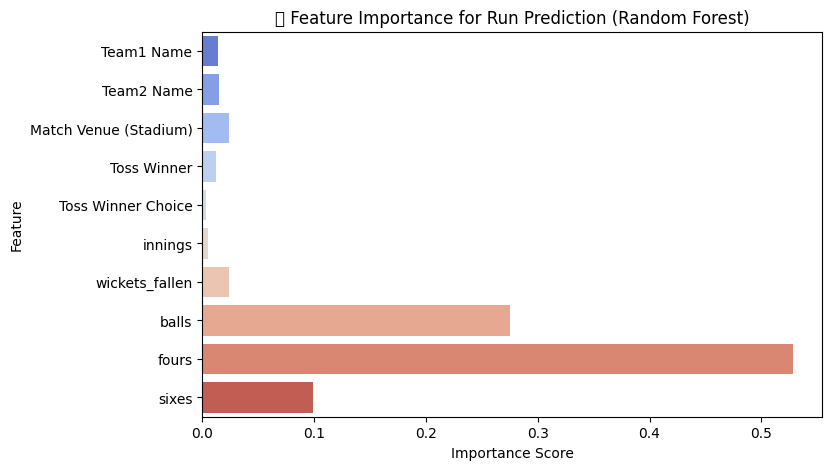

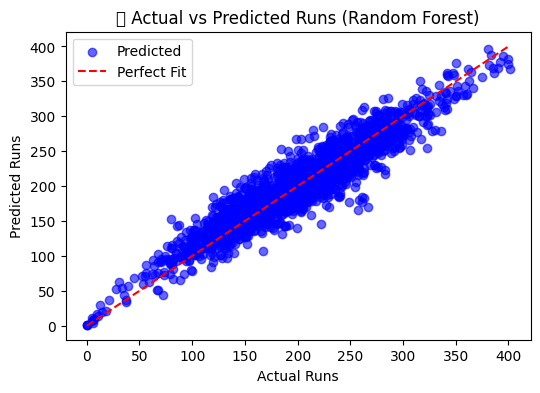

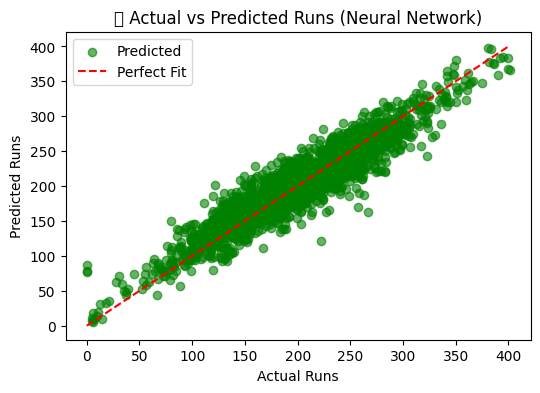

d:\work_D\ODI_NEW\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


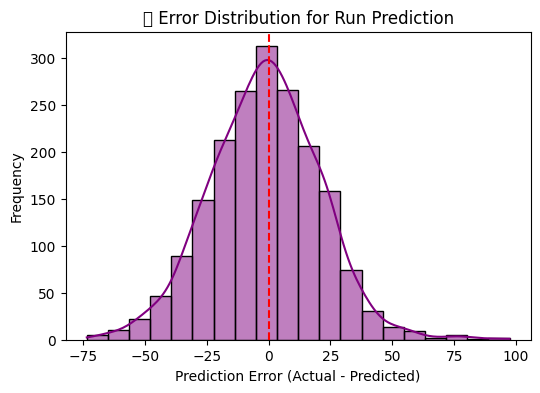

d:\work_D\ODI_NEW\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


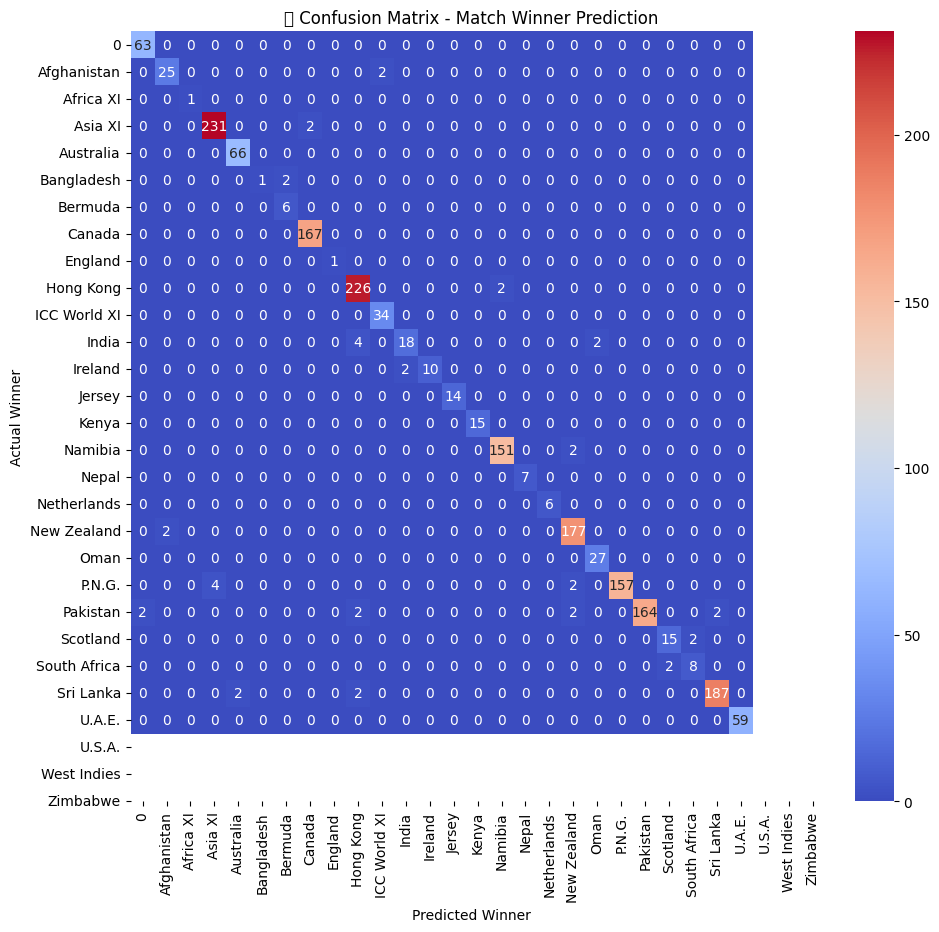

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 🎯 Visualize Feature Importance (Random Forest - Run Prediction)
feature_importance = rf_run_model.feature_importances_
features = X_run.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=features, palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("📊 Feature Importance for Run Prediction (Random Forest)")
plt.show()

# 📈 Actual vs Predicted Runs (Random Forest)
plt.figure(figsize=(6, 4))
plt.scatter(y_run_test, rf_run_preds, alpha=0.6, color="blue", label="Predicted")
plt.plot([min(y_run_test), max(y_run_test)], [min(y_run_test), max(y_run_test)], '--r', label="Perfect Fit")
plt.xlabel("Actual Runs")
plt.ylabel("Predicted Runs")
plt.title("📊 Actual vs Predicted Runs (Random Forest)")
plt.legend()
plt.show()

# 📈 Actual vs Predicted Runs (Neural Network)
plt.figure(figsize=(6, 4))
plt.scatter(y_run_test, nn_run_preds, alpha=0.6, color="green", label="Predicted")
plt.plot([min(y_run_test), max(y_run_test)], [min(y_run_test), max(y_run_test)], '--r', label="Perfect Fit")
plt.xlabel("Actual Runs")
plt.ylabel("Predicted Runs")
plt.title("📊 Actual vs Predicted Runs (Neural Network)")
plt.legend()
plt.show()

# 📉 Error Distribution for Run Prediction (Random Forest)
errors = y_run_test - rf_run_preds
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=20, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("📊 Error Distribution for Run Prediction")
plt.show()

# 🎯 Confusion Matrix for Match Winner Prediction
conf_matrix = confusion_matrix(y_winner_test, rf_winner_preds)
plt.figure(figsize=(11, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm", xticklabels=label_encoders['Match Winner'].classes_, yticklabels=label_encoders['Match Winner'].classes_)
plt.xlabel("Predicted Winner")
plt.ylabel("Actual Winner")
plt.title("🏆 Confusion Matrix - Match Winner Prediction")
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dictionary to store model predictions
models = {
    "Random Forest": rf_run_preds,
    "Neural Network": nn_run_preds,
    "Gradient Boosting": gb_run_preds,
    "XGBoost": xgb_run_preds
}

# Calculate and store metrics
mae_scores = {name: mean_absolute_error(y_run_test, preds) for name, preds in models.items()}
rmse_scores = {name: (mean_squared_error(y_run_test, preds)) ** 0.5 for name, preds in models.items()}  # Manual RMSE
r2_scores = {name: r2_score(y_run_test, preds) for name, preds in models.items()}

# Print model comparisons
print("\n📊 Model Comparison for Run Prediction:")
print("---------------------------------------------------")
print(f"{'Model':<20}{'MAE':<15}{'RMSE':<15}{'R² Score':<15}")
print("---------------------------------------------------")
for model, mae in mae_scores.items():
    print(f"{model:<20}{mae:<15.3f}{rmse_scores[model]:<15.3f}{r2_scores[model]:<15.3f}")



📊 Model Comparison for Run Prediction:
---------------------------------------------------
Model               MAE            RMSE           R² Score       
---------------------------------------------------
Random Forest       17.455         22.284         0.879          
Neural Network      17.529         22.455         0.877          
Gradient Boosting   16.873         21.420         0.888          
XGBoost             16.332         20.842         0.894          


<Figure size 700x500 with 0 Axes>

d:\work_D\ODI_NEW\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


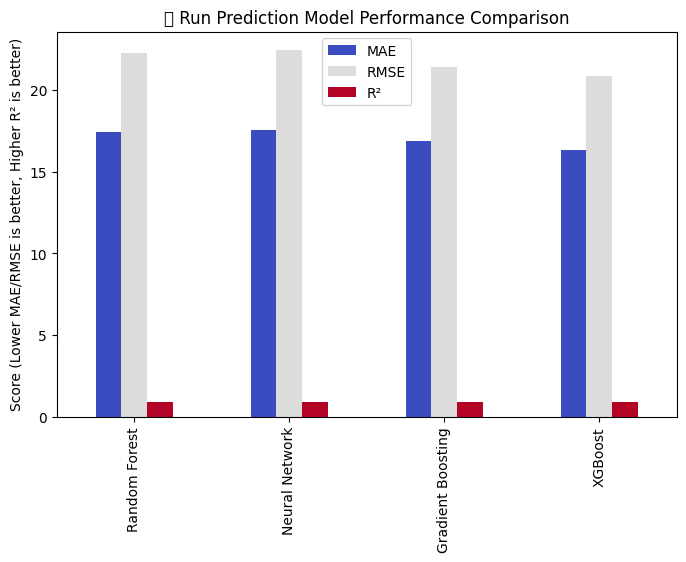

C:\Users\DeepaliMadala\AppData\Local\Temp\ipykernel_16328\3514417300.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")
d:\work_D\ODI_NEW\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


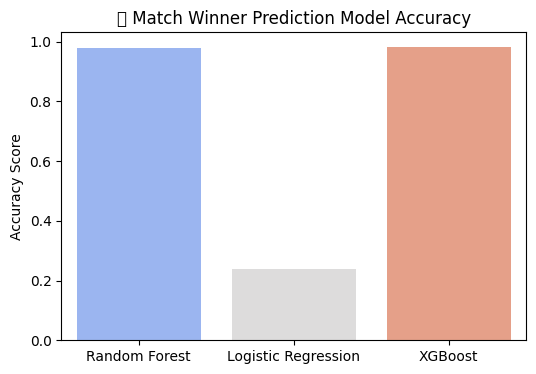

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression

# Train Gradient Boosting for Run Prediction
gb_run_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_run_model.fit(X_run_train, y_run_train)
gb_run_preds = gb_run_model.predict(X_run_test)

# Train XGBoost for Run Prediction
xgb_run_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_run_model.fit(X_run_train, y_run_train)
xgb_run_preds = xgb_run_model.predict(X_run_test)

# Train Logistic Regression for Winner Prediction
log_reg_winner_model = LogisticRegression()
log_reg_winner_model.fit(X_winner_train, y_winner_train)
log_reg_winner_preds = log_reg_winner_model.predict(X_winner_test)

# Train XGBoost for Winner Prediction
xgb_winner_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_winner_model.fit(X_winner_train, y_winner_train)
xgb_winner_preds = xgb_winner_model.predict(X_winner_test)

# Evaluate Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score

# Run Prediction Performance
models = {
    "Random Forest": rf_run_preds,
    "Neural Network": nn_run_preds,
    "Gradient Boosting": gb_run_preds,
    "XGBoost": xgb_run_preds
}

mae_scores = {name: mean_absolute_error(y_run_test, preds) for name, preds in models.items()}
rmse_scores = {name: mean_squared_error(y_run_test, preds) ** 0.5 for name, preds in models.items()}
r2_scores = {name: r2_score(y_run_test, preds) for name, preds in models.items()}

# Winner Prediction Performance
winner_models = {
    "Random Forest": rf_winner_preds,
    "Logistic Regression": log_reg_winner_preds,
    "XGBoost": xgb_winner_preds
}
accuracy_scores = {name: accuracy_score(y_winner_test, preds) for name, preds in winner_models.items()}

# 📊 Visualization - Run Prediction Model Performance
plt.figure(figsize=(7, 5))
metrics_df = pd.DataFrame([mae_scores, rmse_scores, r2_scores], index=["MAE", "RMSE", "R²"])
metrics_df.T.plot(kind="bar", figsize=(8, 5), colormap="coolwarm")
plt.title("📊 Run Prediction Model Performance Comparison")
plt.ylabel("Score (Lower MAE/RMSE is better, Higher R² is better)")
plt.show()

# 📊 Visualization - Winner Prediction Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")
plt.ylabel("Accuracy Score")
plt.title("🏆 Match Winner Prediction Model Accuracy")
plt.show()
